# EDA

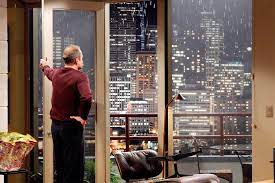

In [2]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
df = pd.read_csv('data/eda.csv')

In [ ]:
#Explore
df.describe()
df.isna().sum()
df[df['lat'].isna()]
np.sort(df['lat'].unique())
np.sort(df['lat'].value_counts())

In [ ]:
#Analysis
renovated = df[df['yr_renovated'] > 0]
not_renovated = df[(df['yr_renovated'] == 0) | (df['yr_renovated'].isna())]
print('Num of renovated:', renovated.shape[0])
print('Num of not renovated:', not_renovated.shape[0])

has_basement = df[df['sqft_basement']>0]
no_basement = df[(df['sqft_basement'] == 0) | (df['sqft_basement'].isna())]
print('Average price with basement: ', round(has_basement['price'].mean()))
print('Average price with basement: ', round(no_basement['price'].mean()))

Apartments = df.duplicated(subset=['lat', 'long'], keep=False)
Apartments.any()
df[Apartments].sort_values(['lat', 'long'])

In [3]:
#Cleaning - yr_renovated - change dtype to date (Y) - replace 0 to np.nan so 0 will be NaT
df['yr_renovated'] = pd.to_datetime(df['yr_renovated'].replace(0, np.nan), format='%Y')

#Cleaning - transform - remove 0. from the end of yr_renovated and change to int
df['yr_renovated'] = (df['yr_renovated']/10).astype(int)

ValueError: unconverted data remains when parsing with format "%Y": "0", at position 1. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [4]:
#Cleaning - rename columns
df = df.rename(columns={'view': 'num_of_views'})

#Cleaning - transform - Bathroom round up to the nearest half
df['bathrooms'].value_counts().sort_index()
df['bathrooms'] = np.ceil(df['bathrooms']*2)/2
df.head(5)

#Cleaning - transform -remove bedroom outliers
outlier_index = df.query('bedrooms == 33').index
df = df.drop(outlier_index)

#Cleaning - transforms - gets rows where living is bigger than lot and transforms lot = living
lot_bigger_living = df['sqft_living'] > df['sqft_lot']
df.loc[lot_bigger_living, 'sqft_lot'] = df.loc[lot_bigger_living, 'sqft_living']

#Cleaning - transform - graade column to classes and groups
df['grade_class'] = df['grade'].map({
    3:'Below minimum building standards, often cabins or very basic structures.',
    4:'Older and low-quality; likely below modern building codes.',
    5:'Simple, low-cost designs with basic workmanship.',
    6:'Meets current code but is still on the low end of materials and design.',
    7:'Average build quality, commonly found in standard subdivisions.',
    8:'Slightly above average, better materials and finish quality.',
    9:'Enhanced architectural design with improved interior and exterior finishes.',
    10:'High-quality homes with high-end features and finishes.',
    11:'Custom-designed homes with rich finishes and luxury amenities.',
    12:'Very high-end custom homes with premium materials and detailing.',
    13:'Mansion-level, custom-built for luxury with top-tier fixtures and finishes',})
df['grade_class_group'] = df['grade'].map({
    3:'Low Grade (3-5)',
    4:'Low Grade (3-5)',
    5:'Low Grade (3-5)',
    6:'Medium Grade (6-9)',
    7:'Medium Grade (6-9)',
    8:'Medium Grade (6-9)',
    9:'Medium Grade (6-9)',
    10:'High Grade (10-13)',
    11:'High Grade (10-13)',
    12:'High Grade (10-13)',
    13:'High Grade (10-13)'}) 

In [5]:
#Clean - missing values - fill yr_renovated column with 0 because there are much more that are no renovated and hard to predict the year
df['yr_renovated'] = df['yr_renovated'].fillna(0.0)
df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

#Clean - missing values - fill sqft_basement column with 0 because you cannot guess the size even if it has one.
df['sqft_basement'] = df['sqft_basement'].fillna(0.0)

#Cleaning - missing values - fill num_of_views with mode
df['num_of_views'] = df['num_of_views'].fillna(df['num_of_views'].mode()[0])

#Cleaning - waterfront - Fill waterfront with Zips with or without waterfront views to 0 or 1:
no_waterfront_zip = ((df['zipcode'].isin([98001, 98002, 98003, 98005, 98007, 98010, 98014, 98019, 98022, 98023, 98024, 98027, 
                                          98028, 98029, 98030, 98031, 98032, 98038, 98042, 98045, 98053, 98055, 
                                          98056, 98058, 98059, 98065, 98072, 98077, 98092, 98106, 98108, 98122, 98133, 98146, 
                                          98148, 98155, 98166, 98168, 98178, 98188, 98198, 98011, 98052])) 
                        & (df['waterfront'].isna()))
with_waterfront_zip = ((df['zipcode'].isin([98102, 98103, 98105, 98107, 98109, 98112, 98115, 98116, 98117,
                                              98118, 98119, 98125, 98126, 98136, 98144, 98177, 98199, 98004, 98006, 
                                              98008, 98033, 98034, 98039, 98040, 98074, 98075, 98070])) 
                                              & (df['waterfront'].isna()))
df.loc[no_waterfront_zip, 'waterfront'] = 0
df.loc[with_waterfront_zip, 'waterfront'] = 1

In [6]:
#Cleaning - waterfront - change dtype
df['waterfront'] = df['waterfront'].astype(bool)

#Cleaning - yr_built - change dtype to date (Y)
df['yr_built'] = pd.to_datetime(df['yr_built'], format='%Y')

#Cleaning - yr_built - change dtype to date
df['date'] = pd.to_datetime(df['date'])

#Cleaning - bedrooms - change dtype to int
df['bedrooms'] = df['bedrooms'].astype(int)

#Cleaning - num_of_views - change dtype to int
df['num_of_views'] = df['num_of_views'].astype(int)

#Cleaning - price - change dtype to int
df['price'] = df['price'].astype(int)


#  Right-skewed

The data in the sqft_living column was right skewed with which means most houses were relatively small but there are a few houses that drag the average higher.

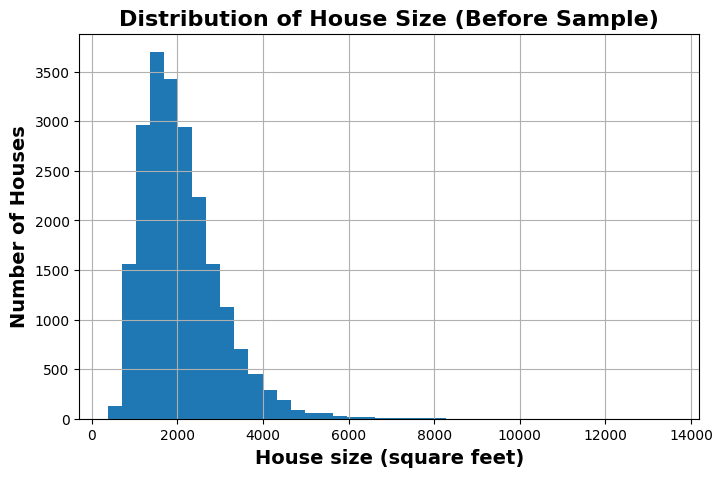

In [20]:
plt.figure(figsize=(8, 5))
df['sqft_living'].hist(bins=40)
plt.xlabel('House size (square feet)', fontsize=14, fontweight='bold')
plt.ylabel('Number of Houses', fontsize=14, fontweight='bold')
plt.title('Distribution of House Size (Before Sample)', fontsize=16, fontweight='bold')
plt.show()

In [7]:
# Define lower & upper bounds
lower = 300
upper = 4000
# Filter the DataFrame
df_sqft_living_sample = df[(df['sqft_living'] >= lower) & (df['sqft_living'] <= upper)].reset_index()
print(f"Original rows: {len(df)}")
print(f"Sample rows: {len(df_sqft_living_sample)}")
print((len(df_sqft_living_sample)/len(df))*100)

Original rows: 21596
Sample rows: 20814
96.37895906649379


# More normally distributed.

The distribution of Data for the column sqft_living is now much more evenly spread

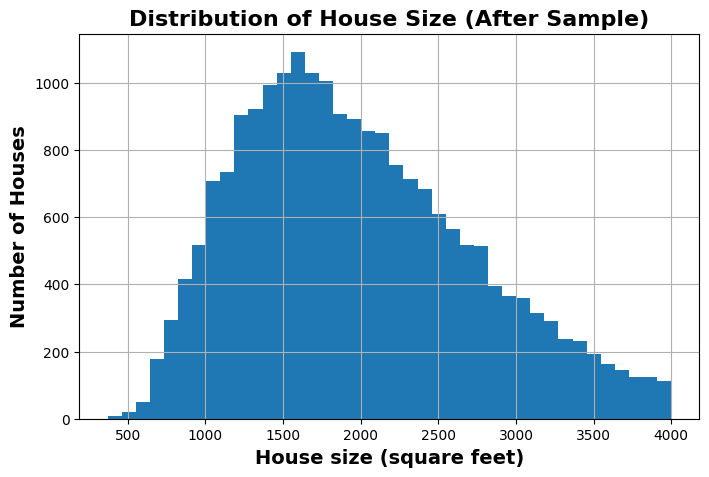

In [22]:
plt.figure(figsize=(8, 5))
df_sqft_living_sample['sqft_living'].hist(bins=40)
plt.xlabel('House size (square feet)', fontsize=14, fontweight='bold')
plt.ylabel('Number of Houses', fontsize=14, fontweight='bold')
plt.title('Distribution of House Size (After Sample)', fontsize=16, fontweight='bold')
plt.show()

# Hypothesis 1
- Higher grade houses usually mean larger houses.

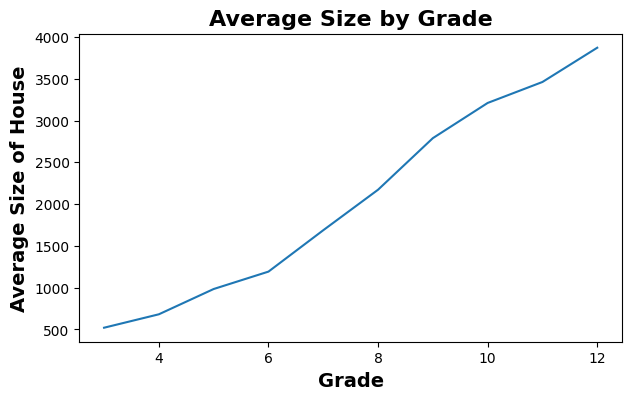

In [8]:
# Calculate average price by grade
avg_size_by_grade = df_sqft_living_sample.groupby('grade')['sqft_living'].mean().reset_index()

# Line plot
plt.figure(figsize=(7, 4))
sns.lineplot(x='grade', y='sqft_living', data=avg_size_by_grade)
plt.xlabel('Grade', fontsize=14, fontweight='bold')
plt.ylabel('Average Size of House', fontsize=14, fontweight='bold')
plt.title('Average Size by Grade', fontsize=16, fontweight='bold')
plt.show()

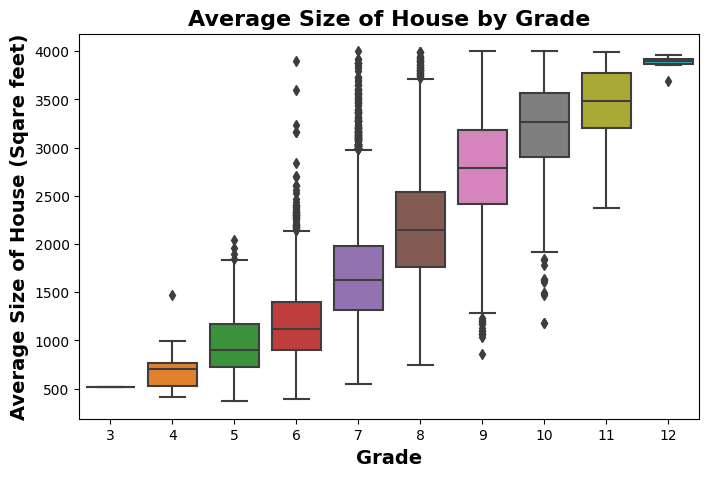

In [8]:
#Boxplot shows a positive correlation between average size and the grade of the house
sns.boxplot(
    x='grade', 
    y='sqft_living', 
    data=df_sqft_living_sample)
plt.xlabel('Grade', fontsize=14, fontweight='bold')
plt.ylabel('Average Size of House (Sqare feet)', fontsize=14, fontweight='bold')
plt.title('Average Size of House by Grade', fontsize=16, fontweight='bold')
plt.show()

Text(0.5, 1.0, 'Relationship bewteen House Size and Grade Class')

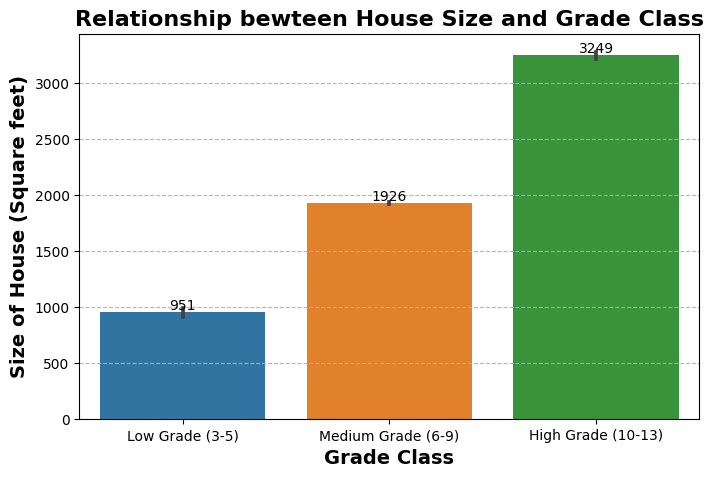

In [9]:
#Barplot - Divided the grades in 3 categories (Low, Medium and High)
ax = sns.barplot(
    data=df_sqft_living_sample, 
    x='grade_class_group', 
    y='sqft_living',
    order=['Low Grade (3-5)', 'Medium Grade (6-9)', 'High Grade (10-13)'])

ax.bar_label(ax.containers[0], fmt='%.0f')
ax.grid(True, axis='y', linestyle='--', alpha=0.9)
plt.xlabel('Grade Class', fontsize=14, fontweight='bold')
plt.ylabel('Size of House (Square feet)', fontsize=14, fontweight='bold')
plt.title('Relationship bewteen House Size and Grade Class', fontsize=16, fontweight='bold')

# Hypothesis 1 
- Pearson's shows 76% Correlations

In [ ]:
#Pearson's Correlation - Both numeric & you assume equal intervals
print("Pearson:", df['grade'].corr(df['sqft_living'], method='pearson'))

Pearson: 0.7627760203230776


# Hypothesis 2
- The condition of the house depends on the year it was built

In [9]:
#Create a new column called 'age of house'
current_year = pd.Timestamp.now().year
df['age_of_house'] = current_year - df['yr_built'].dt.year
df[['yr_built', 'age_of_house']].sort_values('age_of_house', ascending=False)

,yr_built,age_of_house
3878,1900-01-01,125
3973,1900-01-01,125
3915,1900-01-01,125
14,1900-01-01,125
5231,1900-01-01,125
...,...,...
20836,2015-01-01,10
20865,2015-01-01,10
20947,2015-01-01,10
20917,2015-01-01,10


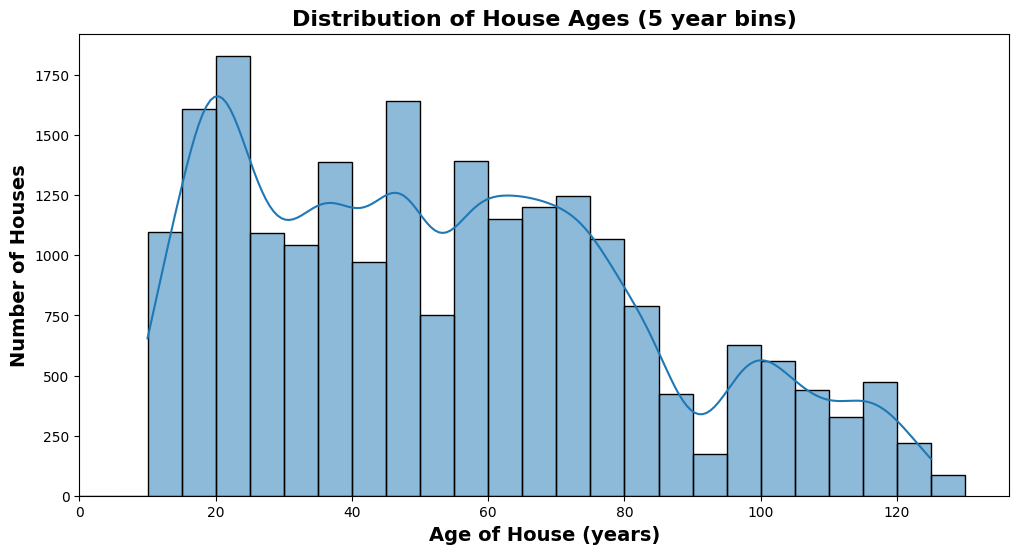

In [17]:
#Histogram - Show the spread of the age of house data in 5 year bins 
bar_bins = np.arange(0, 131, 5)
plt.figure(figsize=(12, 6))
sns.histplot(df['age_of_house'], bins=bar_bins, kde=True)
plt.xlabel('Age of House (years)', fontsize=14, fontweight='bold')
plt.ylabel('Number of Houses', fontsize=14, fontweight='bold')
plt.title('Distribution of House Ages (5 year bins)', fontsize=16, fontweight='bold')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

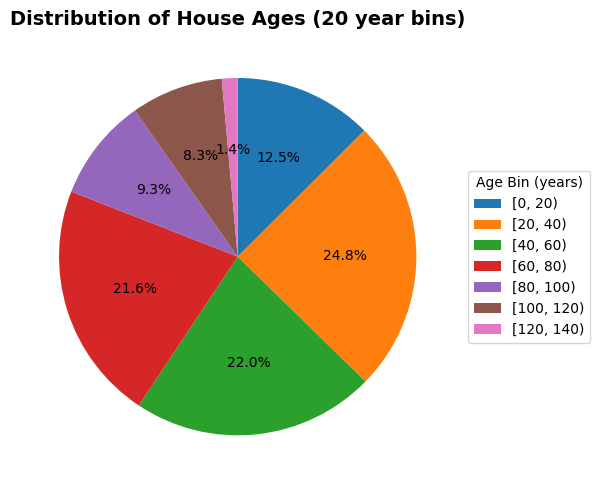

In [10]:
#Bin the data & count
pie_bins = np.arange(0, 141, 20)
df['age_bin'] = pd.cut(df['age_of_house'], bins=pie_bins, right=False)
age_bin_counts = df['age_bin'].value_counts().sort_index()

# Now plot the counts
wedges, texts, autotexts = plt.pie(
    age_bin_counts.values,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False
)

# Add legend with bin labels
plt.legend(
    wedges,
    age_bin_counts.index.astype(str),
    title='Age Bin (years)',
    loc='center left',
    bbox_to_anchor=(1, 0, 0.5, 1)
)

plt.title('Distribution of House Ages (20 year bins)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Relationship between house age and its Condition')

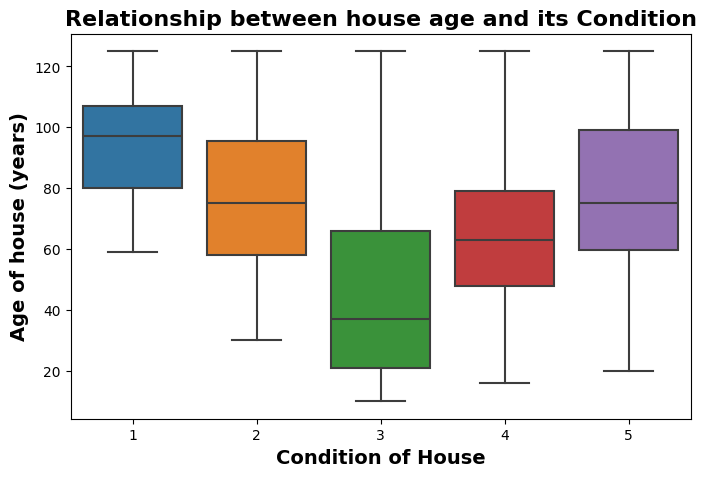

In [33]:
sns.boxplot(data=df, x='condition', y='age_of_house')
plt.xlabel('Condition of House', fontsize=14, fontweight='bold')
plt.ylabel('Age of house (years)', fontsize=14, fontweight='bold')
plt.title('Relationship between house age and its Condition', fontsize=16, fontweight='bold')


Text(0.5, 1.0, 'Relationship between house age and its Condition')

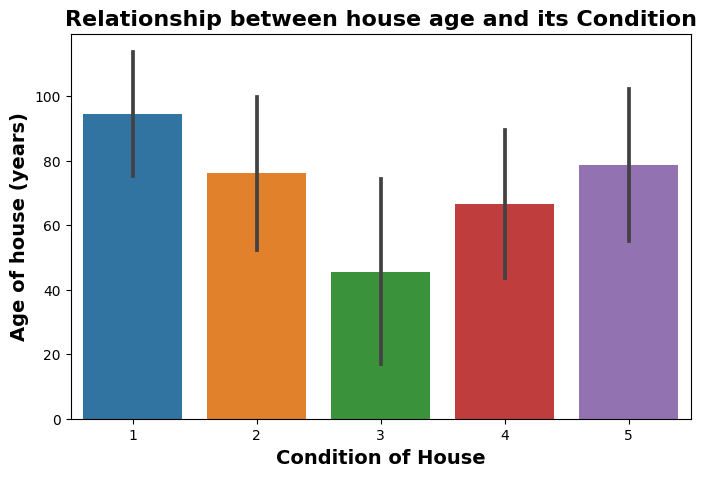

In [12]:
#Barplot - Show relationship between house age and its condition
sns.barplot(x='condition', y='age_of_house', data=df, ci='sd')
plt.xlabel('Condition of House', fontsize=14, fontweight='bold')
plt.ylabel('Age of house (years)', fontsize=14, fontweight='bold')
plt.title('Relationship between house age and its Condition', fontsize=16, fontweight='bold')

# Hypothesis 2 
- Spearman's shows 39% Correlations

In [13]:
# Spearman's Correlation - Categorical (Ordinal) + numeric, monotonic unsure if the steps between grades are perfectly equal - Better choice
print("Spearman:", df['age_of_house'].corr(df['condition'], method='spearman'))

Spearman: 0.39386252851247894


# Hypothesis 3
- Areas that are less central have larger houses.

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopy.distance import geodesic

# Create a geometry point using lat & long
geometry = [Point(xy) for xy in zip(df_sqft_living_sample['long'], df_sqft_living_sample['lat'])]
# Create GeoDataFrame
houses_gdf = gpd.GeoDataFrame(df_sqft_living_sample, geometry=geometry, crs="EPSG:4326") # coordinate reference system's wgs84
# Calculate distance_to_center to seattle city center's lat& long (4)7.6061° N, 122.3328°)
houses_gdf['distance_km'] = houses_gdf.geometry.apply(lambda p: geodesic((p.y, p.x), (47.6061, -122.3328)).km)
# Create 3 columns to see if it's in Urban, suburban and rural
houses_gdf['is_urban_1st_ring'] = houses_gdf['distance_km'] <= 15
houses_gdf['is_suburban_2nd_ring'] = (houses_gdf['distance_km'] > 15) & (houses_gdf['distance_km'] <= 30)
houses_gdf['is_rural_3rd_ring'] = houses_gdf['distance_km'] > 30
# 3 new variables
urban_1st = houses_gdf[houses_gdf['is_urban_1st_ring'] == True]
suburban_2nd = houses_gdf[houses_gdf['is_suburban_2nd_ring'] == True]
rural_3rd = houses_gdf[houses_gdf['is_rural_3rd_ring'] == True]

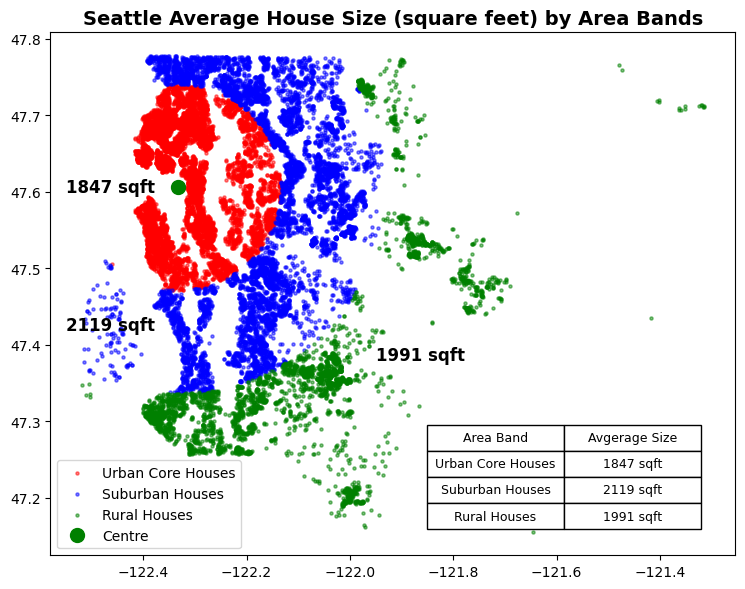

In [15]:
# Geomap - Plot the visualization of the map
fig, ax = plt.subplots(figsize=(8, 6))

# Red : City houses
urban_1st.plot(ax=ax, color='red', markersize=5, alpha=0.5, label='Urban Core Houses')
# Blue : Suburban houses
suburban_2nd.plot(ax=ax, color='blue', markersize=5, alpha=0.5, label='Suburban Houses')
# Green : Rural houses
rural_3rd.plot(ax=ax, color='green', markersize=5, alpha=0.5, label='Rural Houses')

# Plot Seattle Centre
plt.plot(-122.3321, 47.6062, 'go', markersize=10, label='Centre')

#Get average house size of each area band 
avg_size = houses_gdf.groupby(
    ['is_urban_1st_ring', 'is_suburban_2nd_ring', 'is_rural_3rd_ring']
)['sqft_living'].mean()

urban_avg = avg_size[True, False, False]
suburban_avg = avg_size[False, True, False]
rural_avg = avg_size[False, False, True]

# Add average labels
ax.text(-122.55, 47.60, f"{urban_avg:.0f} sqft", color='black', fontsize=12, fontweight='bold')
ax.text(-122.55, 47.42, f"{suburban_avg:.0f} sqft", color='black', fontsize=12, fontweight='bold')
ax.text(-121.95, 47.38, f"{rural_avg:.0f} sqft", color='black', fontsize=12, fontweight='bold')

# Add table
table_data = [
    ['Urban Core Houses', f"{urban_avg:.0f} sqft"],
    ['Suburban Houses', f"{suburban_avg:.0f} sqft"],
    ['Rural Houses', f"{rural_avg:.0f} sqft"]
]

table = ax.table(
    cellText=table_data,
    colLabels=['Area Band', 'Avgerage Size'],
    cellLoc='center',
    loc='lower right',
    bbox=[0.55, 0.05, 0.40, 0.20]
)

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.5)

plt.title('Seattle Average House Size (square feet) by Area Bands', fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
#Place each zipcode in the relevant area band
zip_to_band = {
    # Urban
    98102: 'urban_1st', 98103: 'urban_1st', 98105: 'urban_1st', 98107: 'urban_1st', 98109: 'urban_1st',
    98112: 'urban_1st', 98115: 'urban_1st', 98116: 'urban_1st', 98117: 'urban_1st', 98118: 'urban_1st',
    98119: 'urban_1st', 98122: 'urban_1st', 98126: 'urban_1st', 98136: 'urban_1st', 98144: 'urban_1st',
    98177: 'urban_1st', 98199: 'urban_1st',
    # Suburban
    98004: 'suburban_2nd', 98005: 'suburban_2nd', 98006: 'suburban_2nd', 98007: 'suburban_2nd', 98008: 'suburban_2nd',
    98011: 'suburban_2nd', 98033: 'suburban_2nd', 98034: 'suburban_2nd', 98039: 'suburban_2nd', 98040: 'suburban_2nd',
    98052: 'suburban_2nd', 98053: 'suburban_2nd', 98072: 'suburban_2nd', 98074: 'suburban_2nd', 98075: 'suburban_2nd',
    98125: 'suburban_2nd', 98155: 'suburban_2nd',
    # Rural
    98001: 'rural_3rd', 98002: 'rural_3rd', 98003: 'rural_3rd', 98010: 'rural_3rd', 98014: 'rural_3rd',
    98019: 'rural_3rd', 98022: 'rural_3rd', 98023: 'rural_3rd', 98024: 'rural_3rd', 98027: 'rural_3rd',
    98028: 'rural_3rd', 98029: 'rural_3rd', 98030: 'rural_3rd', 98031: 'rural_3rd', 98032: 'rural_3rd',
    98038: 'rural_3rd', 98042: 'rural_3rd', 98045: 'rural_3rd', 98055: 'rural_3rd', 98056: 'rural_3rd',
    98058: 'rural_3rd', 98059: 'rural_3rd', 98065: 'rural_3rd', 98070: 'rural_3rd', 98077: 'rural_3rd',
    98092: 'rural_3rd', 98106: 'rural_3rd', 98108: 'rural_3rd', 98133: 'rural_3rd', 98146: 'rural_3rd',
    98148: 'rural_3rd', 98166: 'rural_3rd', 98168: 'rural_3rd', 98178: 'rural_3rd', 98188: 'rural_3rd',
    98198: 'rural_3rd',
}

In [13]:
#Place each zipcode in the relevant area name
zip_to_area = {
    # Urban core Seattle ZIPs
    98102: 'Capitol Hill / Eastlake',
    98103: 'Fremont / Wallingford / Green Lake',
    98105: 'UW District / Laurelhurst',
    98107: 'Ballard / Shilshole',
    98109: 'South Lake Union / Queen Anne (lower)',
    98112: 'Madison Park / Washington Park',
    98115: 'Wedgwood / Sand Point',
    98116: 'Alki / West Seattle Beach',
    98117: 'North Ballard / Sunset Hill',
    98118: 'Seward Park / Rainier Beach',
    98119: 'Queen Anne',
    98122: 'Central District / Madison Valley',
    98126: 'Delridge / High Point / West Seattle',
    98136: 'Fauntleroy / Gatewood',
    98144: 'Mount Baker / Judkins Park',
    98177: 'Broadview / Blue Ridge',
    98199: 'Magnolia',

    # Suburban Eastside ZIPs
    98004: 'Downtown Bellevue / Meydenbauer',
    98005: 'Bridle Trails / Wilburton',
    98006: 'Newcastle / Somerset',
    98007: 'Crossroads / East Bellevue',
    98008: 'Lake Hills / Phantom Lake',
    98011: 'Bothell',
    98033: 'Kirkland Downtown',
    98034: 'Juanita / Finn Hill',
    98039: 'Medina',
    98040: 'Mercer Island',
    98052: 'Redmond',
    98053: 'Redmond Ridge / Trilogy',
    98072: 'Woodinville',
    98074: 'Sammamish West',
    98075: 'Sammamish East',
    98125: 'Lake City / Matthews Beach',
    98155: 'Shoreline',

    # Rural/exurban edges
    98001: 'Auburn West',
    98002: 'Auburn',
    98003: 'Federal Way North',
    98010: 'Black Diamond',
    98014: 'Carnation',
    98019: 'Duvall',
    98022: 'Enumclaw',
    98023: 'Federal Way South',
    98024: 'Fall City',
    98027: 'Issaquah South / Cougar Mountain',
    98028: 'Kenmore',
    98029: 'Issaquah Highlands',
    98030: 'Kent East',
    98031: 'Kent North',
    98032: 'Kent West / Industrial',
    98038: 'Maple Valley',
    98042: 'Covington',
    98045: 'North Bend',
    98055: 'Renton East',
    98056: 'Renton Highlands',
    98058: 'Fairwood',
    98059: 'Renton Maplewood',
    98065: 'Snoqualmie',
    98070: 'Vashon Island',
    98077: 'Woodinville Rural',
    98092: 'Auburn South',
    98106: 'Delridge / White Center',
    98108: 'Georgetown / South Park',
    98133: 'Shoreline North',
    98146: 'White Center / Burien North',
    98148: 'Burien West',
    98166: 'Des Moines',
    98168: 'Tukwila / Boulevard Park',
    98178: 'Skyway',
    98188: 'SeaTac',
    98198: 'Des Moines South',
}

In [14]:
#Add urband_band and area_name columns to df_sqfr_living_sample
df_sqft_living_sample['urban_band'] = df_sqft_living_sample['zipcode'].map(zip_to_band)
df_sqft_living_sample['area_name'] = df_sqft_living_sample['zipcode'].map(zip_to_area)

In [15]:
# Merge the sample dataframe to the geometry dataframe by their id
df_sqft_living_sample = df_sqft_living_sample.merge(
    houses_gdf[['id', 'geometry', 'distance_km',
               'is_urban_1st_ring', 'is_suburban_2nd_ring', 'is_rural_3rd_ring']],
    on='id',
    how='left'   # keeps all rows in df
)

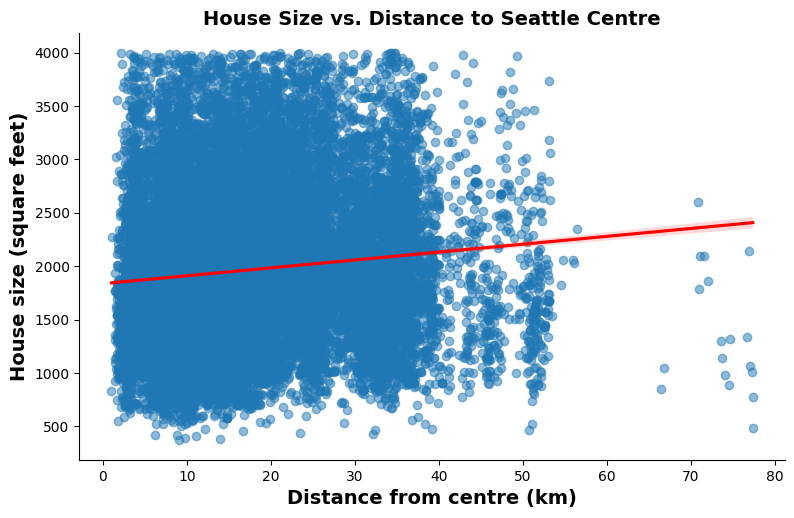

In [20]:
#Scatterplot - Show correlation between house size and distance to centre
sns.lmplot(
    data=df_sqft_living_sample,
    x='distance_km',
    y='sqft_living',
    line_kws={'color': 'red'},
    scatter_kws={'alpha': 0.5},
    height=5,        
    aspect=8/5      
)

plt.title('House Size vs. Distance to Seattle Centre', fontsize=14, fontweight='bold')
plt.xlabel('Distance from centre (km)', fontsize=14, fontweight='bold')
plt.ylabel('House size (square feet)', fontsize=14, fontweight='bold')
plt.show()

Text(0.5, 0, 'Area Band')

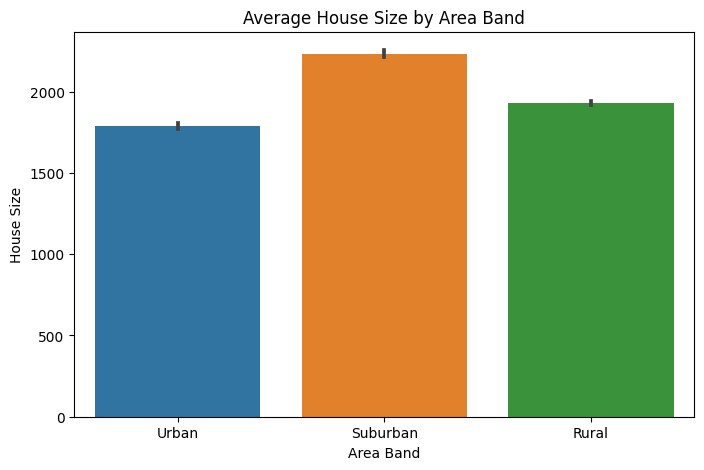

In [ ]:
#Barplot - Average house size by area band
ax = sns.barplot(data=df_sqft_living_sample, x='urban_band', y='sqft_living', order=['urban_1st', 'suburban_2nd', 'rural_3rd'])

ax.set_xticklabels(['Urban', 'Suburban', 'Rural'])
plt.title('Average House Size by Area Band')
plt.ylabel('House Size')
plt.xlabel('Area Band')

# Client Case Study - Nicole

In [16]:
#1 - LIVELY NEIGHBOURHOOD

lively_zips = [98101, 98102, 98103, 98105, 98107, 98109, 98112, 98119, 98121, 98122]
lively_df = df_sqft_living_sample[df_sqft_living_sample['zipcode'].isin(lively_zips)]

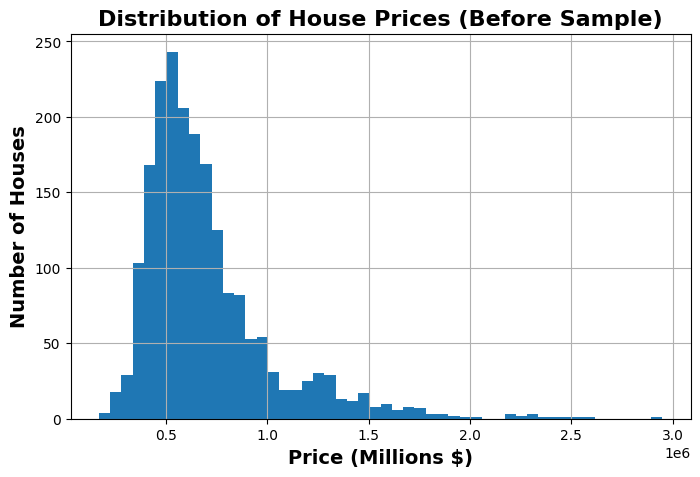

In [17]:
plt.figure(figsize=(8, 5))
lively_df['price'].hist(bins=50)
plt.xlabel('Price (Millions $)', fontsize=14, fontweight='bold')
plt.ylabel('Number of Houses', fontsize=14, fontweight='bold')
plt.title('Distribution of House Prices (Before Sample)', fontsize=16, fontweight='bold')
plt.show()

In [18]:
# Define your lower & upper bounds
lower = 100000
upper = 1200000
# Filter the DataFrame
lively_df_sample = lively_df[(lively_df['price'] >= lower) & (lively_df['price'] <= upper)].reset_index()
print(f"Original rows: {len(lively_df)}")
print(f"Sample rows: {len(lively_df_sample)}")
print((len(lively_df_sample)/len(lively_df))*100)

Original rows: 2008
Sample rows: 1837
91.48406374501991


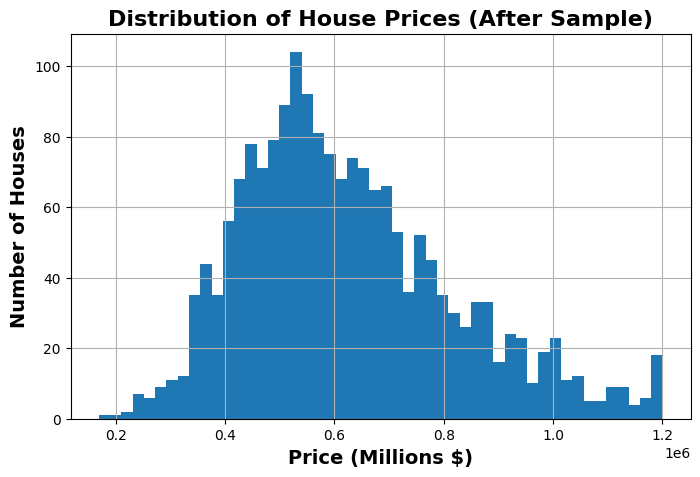

In [19]:
plt.figure(figsize=(8, 5))
lively_df_sample['price'].hist(bins=50)
plt.xlabel('Price (Millions $)', fontsize=14, fontweight='bold')
plt.ylabel('Number of Houses', fontsize=14, fontweight='bold')
plt.title('Distribution of House Prices (After Sample)', fontsize=16, fontweight='bold')
plt.show()

In [20]:
#Group area_name by average price
lively_df_sample.groupby('area_name')['price'].mean().sort_values().round(0)

area_name
Ballard / Shilshole                     558899.000
Fremont / Wallingford / Green Lake      569754.000
Central District / Madison Valley       580152.000
UW District / Laurelhurst               671308.000
Capitol Hill / Eastlake                 707213.000
Queen Anne                              708382.000
South Lake Union / Queen Anne (lower)   717316.000
Madison Park / Washington Park          765073.000
Name: price, dtype: float64

In [ ]:
#Shorten Area names to fit in graphs
lively_df_sample['short_area_name'] = lively_df_sample['area_name'].map({
    'Ballard / Shilshole': 'Ballard',
    'Fremont / Wallingford / Green Lake': 'Fremont',
    'Central District / Madison Valley': 'Central Dist.',
    'Capitol Hill / Eastlake': 'Capitol Hill',
    'UW District / Laurelhurst': 'UW Dist.',
    'Queen Anne': 'Queen Anne',
    'South Lake Union / Queen Anne (lower)': 'SLU',
    'Madison Park / Washington Park': 'Madison Park',
})

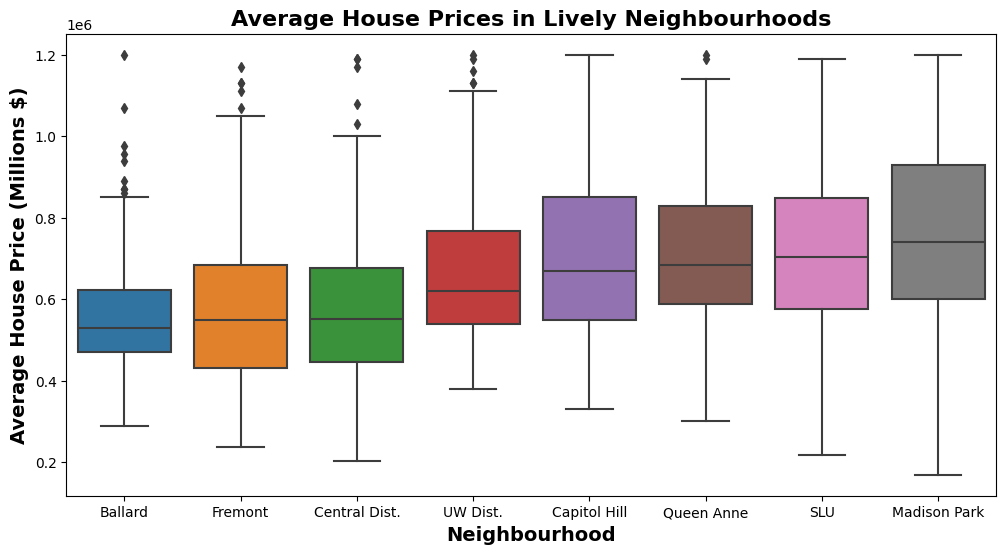

In [ ]:
#2 - MIDDLE PRICE RANGE
#Boxplot - plot average house prices in lively neighbourhods
order = (
    lively_df_sample.groupby('short_area_name')['price']
    .mean()
    .sort_values()
    .index
)

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=lively_df_sample,
    x='short_area_name',
    y='price',
    order=order  # ordered by mean price ascending
)
#plt.ylim(0, 960567.0)
plt.xlabel('Neighbourhood', fontsize=14, fontweight='bold')
plt.ylabel('Average House Price (Millions $)', fontsize=14, fontweight='bold')
plt.title('Average House Prices in Lively Neighbourhoods', fontsize=16, fontweight='bold')
plt.xticks(ha='center')
plt.show()

In [24]:
#Create list of affordable neighbourhood zipcodes - Fremont & Central District
lively_affordable_zips = [98103, 98122]
Lively_affordable = lively_df_sample[lively_df_sample['zipcode'].isin(lively_affordable_zips)]

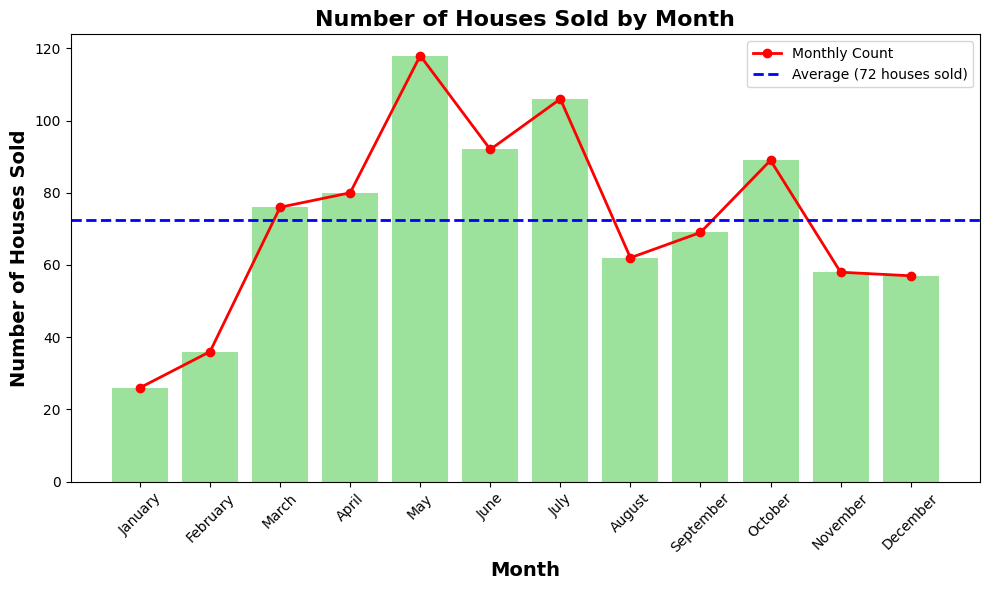

In [ ]:
#3 - RIGHT TIMING (WITHIN A YEAR)
#Barplot - show number of houses sold each month. 

months_labels = ["January", "February", "March", "April", "May", "June",
                 "July", "August", "September", "October", "November", "December"]

# Get counts
monthly_counts = (
    Lively_affordable['month_bins']
    .value_counts()
    .reindex(months_labels)
)

# Average count
mean_count = monthly_counts.mean()

plt.figure(figsize=(10, 6))

# Bars
sns.barplot(
    x=monthly_counts.index,
    y=monthly_counts.values,
    color='lightgreen'
)

# Trend line
plt.plot(
    months_labels,
    monthly_counts.values,
    color='red',
    marker='o',
    linewidth=2,
    label='Monthly Count'
)

# Average line (optional)
plt.axhline(
    mean_count,
    color='blue',
    linestyle='--',
    linewidth=2,
    label=f'Average ({mean_count:.0f} houses sold)'
)

# Labels etc.
plt.xlabel('Month', fontsize=14, fontweight='bold')
plt.ylabel('Number of Houses Sold', fontsize=14, fontweight='bold')
plt.title('Number of Houses Sold by Month', fontsize=16, fontweight='bold')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


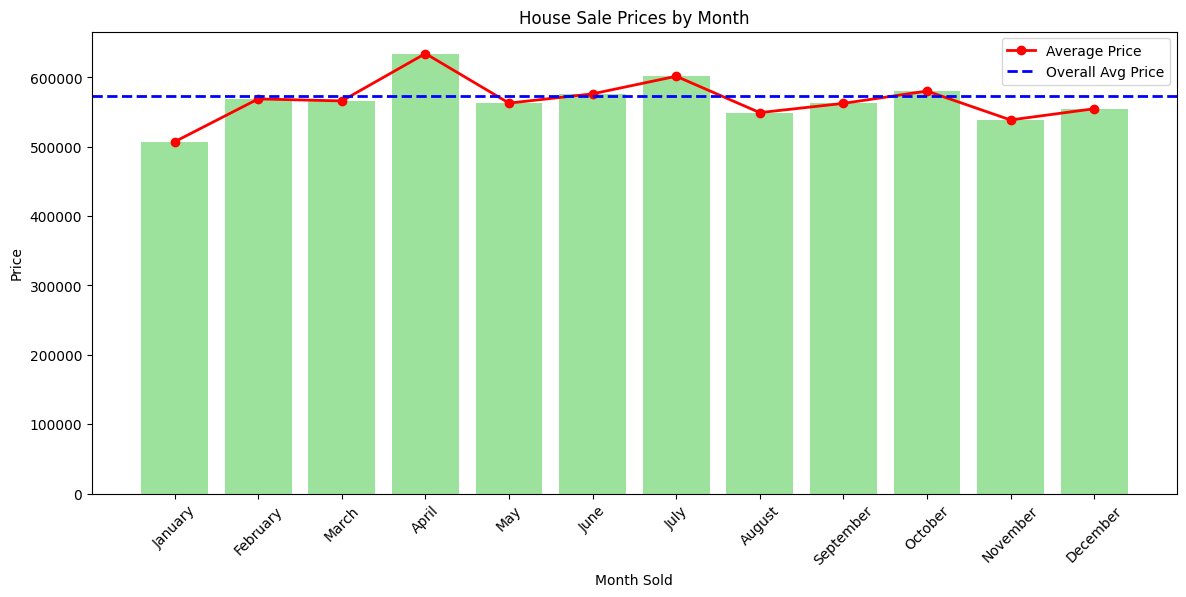

In [30]:
#Barplot - Average price of house sold each month
Lively_affordable["months_sold"] = Lively_affordable["date"].dt.month  # extract months as int to new column
months_labels = ["January", "February", "March", "April", "May", "June",
                 "July", "August", "September", "October", "November", "December"]

Lively_affordable["month_bins"] = pd.cut(Lively_affordable["months_sold"], bins=range(1, 14), labels=months_labels, right=False)

# Calculate overall average price if not already defined
avg_price = Lively_affordable['price'].mean()

plt.figure(figsize=(14, 6))
# Plot average price per month_bin as bars
sns.barplot(
    x='month_bins',
    y='price',
    data=Lively_affordable,
    color='lightgreen',
    ci=None,
    estimator=np.mean
)

# Overlay average price per month_bin as a line
monthly_avg = Lively_affordable.groupby('month_bins')['price'].mean().reindex(months_labels)
plt.plot(months_labels, monthly_avg.values, color='red', marker='o', linewidth=2, label='Average Price')
# Overlay a horizontal line for the overall average price
plt.axhline(avg_price, color='blue', linestyle='--', linewidth=2, label='Overall Avg Price')

plt.xlabel('Month Sold')
plt.ylabel('Price')
plt.title('House Sale Prices by Month')
plt.xticks(rotation=45)
plt.legend()
plt.show()